# Analysis of Reviews

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import string

from scipy.spatial.distance import euclidean, cosine
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords

from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout, Input, Embedding

from tensorflow.keras.optimizers import RMSprop, SGD, Adam

from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


I have used the google drive colab to have access to a GPU and to be able to train the LSTM more comfortably

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '/content/drive/My Drive/SIANI Master/CDI/sentiment_analysis'
!ls '/content/drive/My Drive/SIANI Master/CDI/sentiment_analysis'

'Análisis de Opiniones.ipynb'   reviews_processing_ba.csv
 Reviews.csv		        reviews_processing_un.csv


## Data exploration

In this part, two datasets will be created with the information from the processed texts. Both are manipulated in the same way except that for one a lemmatization and a balancing of its data will be carried out.
 
Due to the large amount of data in this part, each processed set is saved in two CSVs 


In [ ]:
def save_df(text_clean: list, score: pd.Series, name_file: str) -> None:
  df = pd.DataFrame([[text,score] for text, score in zip(text_clean, score)])
  df.columns = ['Text', 'Score']
  df.to_csv(name_file, index = False)

def clean_data(df: pd.Series) -> pd.Series:
  df = df.apply(lambda x: x.lower())
  df = df.apply(lambda x: ''.join([letter for letter in x if letter not in string.punctuation]))
  df = df.apply(lambda x: nltk.word_tokenize(x))
  df = df.apply(lambda x: [letter for letter in x if letter not in stopwords.words('english')])

  return df

def lemmatizer_data(df: pd.Series) -> pd.Series:
  lemmatizer = WordNetLemmatizer()
  df         = df.apply(lambda words: [lemmatizer.lemmatize(word) for word in words])

  return df

A small percentage of the initial data set is extracted for testing

In [ ]:
reviews_df         = pd.read_csv("%s/Reviews.csv" %data_dir)
percentage_of_data = 0.03 # Se estrae un 3% del conjunto incial
reviews_df         = reviews_df.sample(n = round(len(reviews_df) * percentage_of_data))

In [ ]:
save_df(list(reviews_df['Text'].apply(lambda x: nltk.word_tokenize(x))), reviews_df['Score'], "%s/reviews_no_processing.csv" %(data_dir))

In [ ]:
TEXT = clean_data(reviews_df['Text'])
print(reviews_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17054 entries, 340252 to 320516
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      17054 non-null  int64 
 1   ProductId               17054 non-null  object
 2   UserId                  17054 non-null  object
 3   ProfileName             17053 non-null  object
 4   HelpfulnessNumerator    17054 non-null  int64 
 5   HelpfulnessDenominator  17054 non-null  int64 
 6   Score                   17054 non-null  int64 
 7   Time                    17054 non-null  int64 
 8   Summary                 17054 non-null  object
 9   Text                    17054 non-null  object
dtypes: int64(5), object(5)
memory usage: 1.4+ MB
None


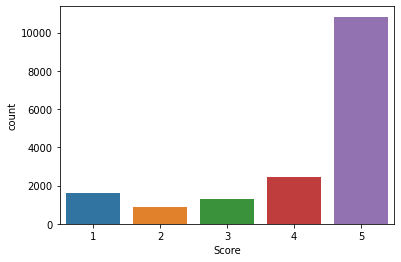

In [ ]:
sns.countplot(x = 'Score', data = reviews_df)

In [ ]:
save_df(TEXT, reviews_df['Score'], "%s/reviews_processing_un.csv" %(data_dir))

A data augmentation process is performed to ensure that the second dataset has the same number of samples per category

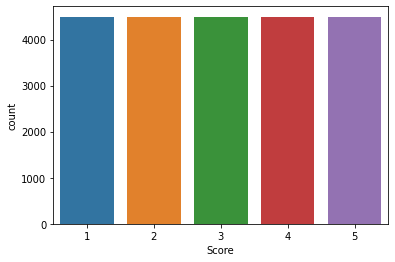

In [ ]:
reviews_df['Text'] = lemmatizer_data(TEXT)
reviews_df = reviews_df.groupby('Score')
reviews_df = pd.DataFrame(reviews_df.apply(
    lambda x: reviews_df.sample(reviews_df.size().min()).reset_index(drop=True)
    )
)

sns.countplot(x = 'Score', data = reviews_df)

In [ ]:
save_df(reviews_df['Text'], reviews_df['Score'], "%s/reviews_processing_ba.csv" %(data_dir))

## Classic NLP

In this part, the matrix of document terms is created using two procedures:
 
* The Boolean model
 
* TF-IDF
 
Testing consists of testing both datasets with the same models: a Decision Tree, a Random Forest, and an AdaBoost.



In [ ]:
from typing import List

class Classifier:
  def __init__(self, clf, name: str):
    self.classifier = clf
    self.name       = name

  def train(self, Xtrain, Ytrain, Xtest, Ytest):
    self.classifier.fit(Xtrain, Ytrain)

    self.predict = self.classifier.predict(Xtest)
    self.Ytest   = Ytest
    self.acc     = round(accuracy_score(Ytest, self.predict)*100, 4)

  def __str__(self):
    try:
      return "%s:\nAccurracy: %s\nRecall and Precision:\n%s" %(self.name, self.acc, classification_report(self.Ytest, self.predict))
    except AttributeError:
      raise RuntimeError("Model not trained")

class ClassifierCollection:
  def __init__(self, collection: List[Classifier] = []) -> None:
      self._collection = collection
  
  def add_classifier(self, classifier: Classifier):
      self._collection.append(classifier)
  
  def train(self, Xtrain, Ytrain, Xtest, Ytest):
    for clf in self._collection:
      clf.train(Xtrain, Ytrain, Xtest, Ytest)
    self._collection.sort(
        key = lambda clf: clf.acc
    )
  
  def __str__(self):
    return ('#'*10 + '\n').join([str(clf) for clf in self._collection])

In [ ]:
def get_train_and_test_samples(df_train: pd.DataFrame, df_test: pd.DataFrame, vectorizer) -> tuple:
  vectorize    = vectorizer(max_features=1000, ngram_range=(1,5))
  Xtrain       = vectorize.fit_transform(df_train['Text']).toarray()
  Xtest        = vectorize.fit_transform(df_test['Text']).toarray()

  encoder      = LabelEncoder()
  Ytrain       = encoder.fit_transform(df_train['Score'])
  Ytest        = encoder.fit_transform(df_test['Score'])
  return (Xtrain, Ytrain, Xtest, Ytest)

def get_collection_of_classifier(clf_collection: ClassifierCollection):
  clf_collection.add_classifier(Classifier(DecisionTreeClassifier(), "Decision Tree"))
  clf_collection.add_classifier(Classifier(RandomForestClassifier(), "Random Forest"))
  clf_collection.add_classifier(Classifier(AdaBoostClassifier(),     "Ada Boost"))

def clasifier_dataset(file: str):
  reviews_df        = pd.read_csv(file)
  df_train, df_test = train_test_split(reviews_df, test_size = 0.20)
  
  Xtrain, Ytrain, Xtest, Ytest = get_train_and_test_samples(df_train, 
                                                          df_test, 
                                                          CountVectorizer)
  clf_collection_cv = ClassifierCollection([])
  get_collection_of_classifier(clf_collection_cv)
  clf_collection_cv.train(Xtrain, Ytrain, Xtest, Ytest)

  print("Utilizando CountVectorizer\n", clf_collection_cv)

  Xtrain, Ytrain, Xtest, Ytest = get_train_and_test_samples(df_train, 
                                                          df_test, 
                                                          TfidfVectorizer)
  
  clf_collection_tf = ClassifierCollection([])
  get_collection_of_classifier(clf_collection_tf)
  clf_collection_tf.train(Xtrain, Ytrain, Xtest, Ytest)
  print("Utilizando TfidfVectorizer\n", clf_collection_tf)

It is extracted how to measure the precision of the models and a report showing the performance by means of the F1-score metric 

In [ ]:
clasifier_dataset("%s/reviews_no_processing.csv" %(data_dir))

Utilizando CountVectorizer
 Decision Tree:
Accurracy: 33.4213
Recall and Precision:
              precision    recall  f1-score   support

           0       0.11      0.20      0.14       328
           1       0.09      0.16      0.11       180
           2       0.08      0.08      0.08       259
           3       0.14      0.25      0.18       450
           4       0.65      0.41      0.51      2194

    accuracy                           0.33      3411
   macro avg       0.21      0.22      0.20      3411
weighted avg       0.46      0.33      0.38      3411
##########
Random Forest:
Accurracy: 63.2073
Recall and Precision:
              precision    recall  f1-score   support

           0       0.20      0.01      0.02       328
           1       0.00      0.00      0.00       180
           2       0.33      0.00      0.01       259
           3       0.17      0.04      0.06       450
           4       0.65      0.97      0.78      2194

    accuracy                       

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Utilizando TfidfVectorizer
 Decision Tree:
Accurracy: 38.9622
Recall and Precision:
              precision    recall  f1-score   support

           0       0.12      0.15      0.13       328
           1       0.03      0.03      0.03       180
           2       0.11      0.05      0.06       259
           3       0.14      0.28      0.18       450
           4       0.63      0.52      0.57      2194

    accuracy                           0.39      3411
   macro avg       0.21      0.20      0.20      3411
weighted avg       0.45      0.39      0.41      3411
##########
Ada Boost:
Accurracy: 62.9727
Recall and Precision:
              precision    recall  f1-score   support

           0       0.12      0.02      0.03       328
           1       0.17      0.01      0.01       180
           2       0.15      0.02      0.03       259
           3       0.18      0.03      0.05       450
           4       0.65      0.97      0.78      2194

    accuracy                           

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
clasifier_dataset("%s/reviews_processing_un.csv" %data_dir)

Utilizando CountVectorizer
 Decision Tree:
Accurracy: 30.3723
Recall and Precision:
              precision    recall  f1-score   support

           0       0.09      0.23      0.13       300
           1       0.05      0.04      0.05       181
           2       0.08      0.19      0.11       258
           3       0.13      0.16      0.15       475
           4       0.64      0.38      0.48      2197

    accuracy                           0.30      3411
   macro avg       0.20      0.20      0.18      3411
weighted avg       0.45      0.30      0.35      3411
##########
Random Forest:
Accurracy: 53.4741
Recall and Precision:
              precision    recall  f1-score   support

           0       0.09      0.12      0.10       300
           1       0.09      0.01      0.01       181
           2       0.13      0.15      0.14       258
           3       0.21      0.01      0.03       475
           4       0.66      0.79      0.72      2197

    accuracy                       

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
clasifier_dataset("%s/reviews_processing_ba.csv" %data_dir)

Utilizando CountVectorizer
 Decision Tree:
Accurracy: 20.2971
Recall and Precision:
              precision    recall  f1-score   support

           0       0.20      0.31      0.24       862
           1       0.22      0.19      0.21       888
           2       0.17      0.18      0.17       861
           3       0.27      0.15      0.19       878
           4       0.21      0.18      0.19       886

    accuracy                           0.20      4375
   macro avg       0.21      0.20      0.20      4375
weighted avg       0.21      0.20      0.20      4375
##########
Ada Boost:
Accurracy: 21.92
Recall and Precision:
              precision    recall  f1-score   support

           0       0.21      0.58      0.31       862
           1       0.26      0.04      0.07       888
           2       0.19      0.05      0.08       861
           3       0.30      0.09      0.14       878
           4       0.22      0.34      0.26       886

    accuracy                           0.

## Deep Learning

In this part, both sets will be tested on an LSTM, and their performance will be measured with the same metric as the previous models. 

In [ ]:
def net(max_words, max_len):
  inputs = Input(name='inputs', shape=[max_len])
  layer  = Embedding(max_words, 50, input_length=max_len)(inputs)
  layer  = LSTM(64)(layer)
  layer  = Dense(256, name = 'FC1')(layer)
  layer  = Activation('relu')(layer)
  layer  = Dropout(0.5)(layer)
  layer  = Dense(5, name='output_layer')(layer)
  layer  = Activation('softmax')(layer)

  model  = Model(inputs=inputs, outputs=layer)

  return model

def test_with_networks(file, batch_size = 16, epochs = 50, validation_split = 0.1):
  reviews_df        = pd.read_csv(file)
  df_train, df_test = train_test_split(reviews_df, test_size = 0.20)

  X_train = df_train.Text
  Y_train = df_train.Score

  X_test = df_test.Text
  Y_test = df_test.Score

  le = LabelEncoder()
  Y_train = le.fit_transform(Y_train)
  Y_test  = le.transform(Y_test)

  Y_train = Y_train.reshape(-1, 1)
  Y_test  = Y_test.reshape( -1, 1)

  enc = OneHotEncoder()
  Y_train = enc.fit_transform(Y_train)
  Y_test  = enc.transform(Y_test)

  Y_train = Y_train.toarray()
  Y_test  = Y_test.toarray()

  max_words = 1000
  max_len   = 150
  tok       = Tokenizer(num_words=max_words) 
  tok.fit_on_texts(X_train)

  sequences       = tok.texts_to_sequences(X_train)
  sequence_matrix = sequence.pad_sequences(sequences, maxlen=max_len)

  model = net(max_words, max_len)
  model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.0005), metrics = ['accuracy'])

  model.fit(
    sequence_matrix, 
    Y_train, 
    batch_size = batch_size, 
    epochs = epochs, 
    validation_split = validation_split, 
    callbacks = [EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10)]
  )

  test_sequences       = tok.texts_to_sequences(X_test)
  test_sequence_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)

  acc = model.evaluate(test_sequence_matrix, Y_test)
  print('Accuracy test: {:.2f}'.format(acc[1] * 100))

  y_pred = model.predict(test_sequence_matrix, batch_size=16, verbose=1)
  y_pred_bool = np.argmax(y_pred, axis=1)
  # Print f1, precision, and recall scores
  print("#"*10)
  print(classification_report(df_test.Score, y_pred_bool + np.ones(y_pred_bool.shape)))


In [ ]:
test_with_networks("%s/reviews_no_processing.csv" %data_dir)

Epoch 1/50
768/768 [==============================] - 8s 10ms/step - loss: 1.0397 - accuracy: 0.6460 - val_loss: 0.9325 - val_accuracy: 0.6689
Epoch 2/50
768/768 [==============================] - 8s 10ms/step - loss: 0.9088 - accuracy: 0.6645 - val_loss: 0.9112 - val_accuracy: 0.6696
Epoch 3/50
768/768 [==============================] - 8s 10ms/step - loss: 0.8825 - accuracy: 0.6712 - val_loss: 0.9052 - val_accuracy: 0.6769
Epoch 4/50
768/768 [==============================] - 7s 10ms/step - loss: 0.8578 - accuracy: 0.6773 - val_loss: 0.9101 - val_accuracy: 0.6762
Epoch 5/50
768/768 [==============================] - 7s 10ms/step - loss: 0.8292 - accuracy: 0.6911 - val_loss: 0.9411 - val_accuracy: 0.6791
Epoch 6/50
768/768 [==============================] - 7s 10ms/step - loss: 0.8052 - accuracy: 0.6978 - val_loss: 0.9076 - val_accuracy: 0.6755
Epoch 7/50
768/768 [==============================] - 7s 10ms/step - loss: 0.7737 - accuracy: 0.7108 - val_loss: 0.9010 - val_accuracy: 0.6857

In [ ]:
test_with_networks("%s/reviews_processing_un.csv" %data_dir)

Epoch 1/50
768/768 [==============================] - 8s 10ms/step - loss: 1.0296 - accuracy: 0.6476 - val_loss: 0.9616 - val_accuracy: 0.6491
Epoch 2/50
768/768 [==============================] - 7s 10ms/step - loss: 0.9126 - accuracy: 0.6697 - val_loss: 0.9355 - val_accuracy: 0.6549
Epoch 3/50
768/768 [==============================] - 7s 10ms/step - loss: 0.8598 - accuracy: 0.6818 - val_loss: 0.8912 - val_accuracy: 0.6667
Epoch 4/50
768/768 [==============================] - 7s 10ms/step - loss: 0.8028 - accuracy: 0.7032 - val_loss: 0.8988 - val_accuracy: 0.6579
Epoch 5/50
768/768 [==============================] - 7s 10ms/step - loss: 0.7713 - accuracy: 0.7171 - val_loss: 0.9143 - val_accuracy: 0.6689
Epoch 6/50
768/768 [==============================] - 7s 10ms/step - loss: 0.7506 - accuracy: 0.7189 - val_loss: 0.9458 - val_accuracy: 0.6557
Epoch 7/50
768/768 [==============================] - 7s 10ms/step - loss: 0.7314 - accuracy: 0.7281 - val_loss: 0.9468 - val_accuracy: 0.6645

In [ ]:
test_with_networks("%s/reviews_processing_ba.csv" %data_dir)

Epoch 1/50
985/985 [==============================] - 33s 33ms/step - loss: 1.3603 - accuracy: 0.4016 - val_loss: 1.2092 - val_accuracy: 0.4737
Epoch 2/50
985/985 [==============================] - 32s 33ms/step - loss: 1.1144 - accuracy: 0.5474 - val_loss: 1.1404 - val_accuracy: 0.5240
Epoch 3/50
985/985 [==============================] - 32s 33ms/step - loss: 1.0018 - accuracy: 0.6060 - val_loss: 1.0627 - val_accuracy: 0.5760
Epoch 4/50
985/985 [==============================] - 32s 32ms/step - loss: 0.8780 - accuracy: 0.6694 - val_loss: 0.9859 - val_accuracy: 0.6143
Epoch 5/50
985/985 [==============================] - 32s 33ms/step - loss: 0.7688 - accuracy: 0.7169 - val_loss: 0.9006 - val_accuracy: 0.6709
Epoch 6/50
985/985 [==============================] - 32s 33ms/step - loss: 0.6738 - accuracy: 0.7481 - val_loss: 0.8782 - val_accuracy: 0.6811
Epoch 7/50
985/985 [==============================] - 32s 33ms/step - loss: 0.6035 - accuracy: 0.7764 - val_loss: 0.8222 - val_accuracy:

## Conclusions



We observe that within the ** classic NLP ** the use of the ** TF-IDF method ** for the creation of the matrix of document terms generates in most cases better solutions depending on the type of classifier we are using, the best The classifier within those tested has been the *** Random Forest *** with unbalanced and raw data with an accuracy of ** 64% **. On the other hand, we can observe that for the other data set we obtain very poor solutions in comparison. This is not true in the case of the ** connectionist approach **, the *** LSTM *** generates very good results for balanced data sets compared to the unbalanced, so much so that the best results are achieved Using this method with ** 86% ** precision and a very good F1-score metric for each class. This could be improved by doing a study of the hyperparameters, but since it is a class exercise, that part has been avoided, also if it were with higher computing power, the entire dataset could be tested without the need to trim the vast majority of samples. In sum, we can see that the connectionist approach generates better results for the same data sets.